In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function for cropping and then warping the image
def warp_image(img, left, right):
    # Get the dimensions of the image
    (image_h, image_w, _) = img.shape

    # Set the car position to the center of the window
    car_pos = ((right - left) / 2) + left
    car_pos = np.array([car_pos, image_h-1], dtype=int)

    # Warp the image to get an areal view
    src = np.float32([[0, image_h], [image_w, image_h], [0,0], [image_w, 0]])
    dst = np.float32([[left,image_h], [right, image_h], [0,0], [image_w, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)  # Use to unwarp the image

    img_warped = cv2.warpPerspective(img, M, (image_w, image_h))

    return img_warped, car_pos, Minv



In [3]:
# Takes an image and returns a filtered binary image
def get_binary_image(img, lower, upper):
    # Convert to HSV color space
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Filter out the specified color
    img_filtered = cv2.inRange(img_hsv, lower, upper)

    # Divide by 255 to convert to binary
    img_bin = img_filtered / 255

    return img_bin



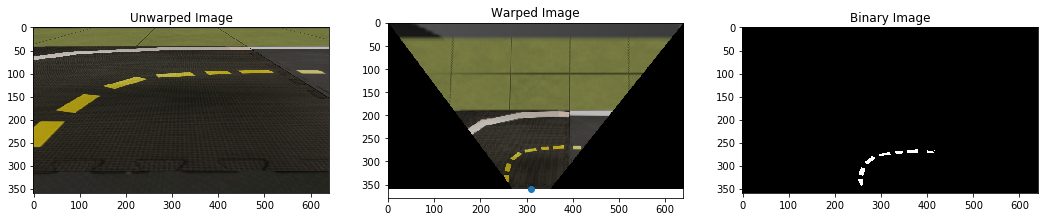

In [4]:
# Load the image
image_file = 'duckietown_images/bend2.png' #'duckietown_images/20201204-125955.png'
img = cv2.imread(image_file)

fig, ax = plt.subplots(1,3, figsize=(18,12))

# Cut the image
img = img[120::, :]
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Unwarped Image')


# Warp the image
new_left = 270
new_right = 350
img_warped, car_pos, Minv = warp_image(img, new_left, new_right)


# Show the warped image
ax[1].imshow(cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB))
ax[1].scatter(car_pos[0], car_pos[1])
ax[1].set_title('Warped Image')

# Filter out the yellow dotted lines and get binary image
yellow_lower = np.array([20, 100, 150])
yellow_upper = np.array([30, 255, 255])

red_lower = np.array( [[0, 100, 100], [160, 100, 100]] )
red_upper = np.array( [[160, 100, 100], [179, 255, 255]] )

img_bin = get_binary_image(img_warped, yellow_lower, yellow_upper)
img_bin_red = get_binary_image(img_warped[-50::,:,:], red_lower[0], red_upper[0])
img_bin_red += get_binary_image(img_warped[-50::,:,:], red_lower[1], red_upper[1])

#img_bin_red = img_bin_red1 + img_bin_red2

ax[2].imshow(img_bin, cmap=plt.cm.gray)
ax[2].set_title('Binary Image')

if 1 in img_bin_red:
    print("At intersection")

plt.show()


In [5]:
# Takes binary image and estimates the center lane line
def estimate_lane(img, window_h=70, window_w=50):
    data = np.argwhere(img == 1)

    start_pos = np.argmax(data[:,0])
    start_pos = data[start_pos,:]

    # Get the middle point for each row
    # Only look at points within the window dimensions
    # For each row, shift the window to be centered at the previous middle point
    points = []
    middle = 0
    left = 0
    for i in range(window_h):
        y = start_pos[0] - i
        if i == 0:
            # For the first row, look in the entire row
            row = img[y,::]
            
        else:
            # Compute left and right bounds to look in
            left = middle - window_w // 2
            right = middle + window_w // 2
            row = img[y, left:right]

        # Find all the points in the row thats a 1
        ones = np.where(row)

        # Recordthe middle point 
        if ones[0].size != 0:
            middle = int(np.mean(ones)) + left
            points.append([y, middle])

    # Convert to numpy array
    points = np.asarray(points)

    # Fit the points to a 1-degree polynomial
    p_lin = np.polyfit(points[:,1], points[:,0], 1)
    p_lin = np.poly1d(p_lin)


    return p_lin, data


In [6]:
# Estimate the lane
p_lin, points = estimate_lane(img_bin, window_h=50, window_w=100)

print('Estimated Linear Function:')
print(p_lin)



Estimated Linear Function:
 
-2.397 x + 941


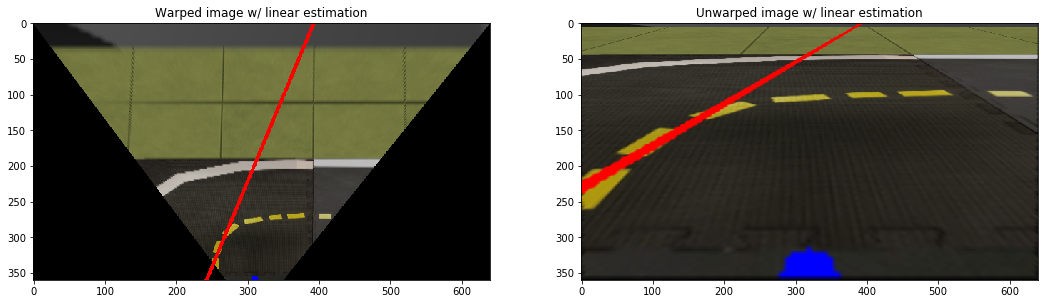

In [7]:
# Draw the estimate back onto the image
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
(image_h, image_w, _) = img_warped.shape

# Draw the 1 degree polynomial estimate on the image
img_warped_lin = np.copy(img_warped)
p1 = (0, int(p_lin(0))) # ( new_left, int(p_lin(new_left)) )
p2 = (image_w-1, int(p_lin(image_w-1))) #( new_right, int(p_lin(new_right)) )
cv2.line(img_warped_lin, p1, p2, (0, 0, 255), 3)

# Put a circle where the car is
cv2.circle(img_warped_lin, (car_pos[0], car_pos[1]), radius = 5, color=(255, 0, 0), thickness=-1)


# Unwarp the images
img_unwarped_lin = cv2.warpPerspective(img_warped_lin, Minv, (image_w, image_h))


# Show the images
ax[0].imshow(cv2.cvtColor(img_warped_lin, cv2.COLOR_BGR2RGB))
ax[0].set_title('Warped image w/ linear estimation')

ax[1].imshow(cv2.cvtColor(img_unwarped_lin, cv2.COLOR_BGR2RGB))
ax[1].set_title('Unwarped image w/ linear estimation')


plt.show()

In [8]:
# Compute the angle from the estimated line
# positive angle -> turn right
# negative angle -> turn left

theta = -math.atan2(1, p_lin[1])

if theta > math.pi/2:
    theta = theta - math.pi
if theta < -math.pi/2:
    theta = math.pi + theta


print('Theta = {:.2f} rad ({:.2f} degrees)'.format(theta, 180*theta/ math.pi))


Theta = 0.40 rad (22.65 degrees)


In [9]:
# Estimate the distance the car is from the center line
y = car_pos[1]  # Car's y position

x = (y - p_lin[0]) / p_lin[1]

# Compute the distance
distance_from_center = car_pos[0] - x
print('\nDistance from Center = {:.2f}'.format(distance_from_center))



Distance from Center = 67.18
